# Mount Drive

In [1]:
# 1) Mount Google Drive (DO NOT EDIT)

# from google.colab import drive
# drive.mount('/content/drive')

# High quality image
%config InlineBackend.figure_format = 'png'

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-Learn Models & Tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
# === EDIT THIS CELL ONLY ===
# set file name
TRAIN_PATH = "../Group_Assignment_Database/UNSW_NB15_training-set.csv"
TEST_PATH = "../Group_Assignment_Database/UNSW_NB15_testing-set.csv"

# =====================================
train_csv_raw = pd.read_csv(TRAIN_PATH)
test_csv_raw = pd.read_csv(TEST_PATH)


# Dataset Loader

In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

def load_and_prep_data():
    train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'
    
    # Juwon's Local file path
    test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'
    
    # 1. Load both datasets
    print("Loading data...")
    df_train_orig = pd.read_csv(train_path)
    df_test_orig = pd.read_csv(test_path)

    # 2. Combine them
    df_full = pd.concat([df_train_orig, df_test_orig], axis=0).reset_index(drop=True)

    missing_data = df_full.isnull().sum()
    if missing_data.sum() > 0:
        print("\n[WARNING] Missing values detected:")
        print(missing_data[missing_data > 0])
    else:
        print("\n[CHECK] No true missing values (NaN) found.")

    # 3. Define Features and Target
    # We use 'label' for stratification to maintain class balance
    drop_cols = ['label', 'id', 'attack_cat']
    X = df_full.drop(drop_cols, axis=1)
    y = df_full['label']
    
    # 4. Stratified Split: Train (70%) and Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 5. Split Temp into Validation (15%) and Test (15%)
    # 0.5 * 30% = 15%
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Now X_train, X_val, X_test/ y_train, y_val, y_test available
    
    # 6. Preprocessing (Label Encoding)
    le = LabelEncoder()
    categorical_cols = ['proto', 'service', 'state'] # attack_cat removed since already dropped
    for col in categorical_cols:
        # labelEncode each train/test/validation data
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.fit_transform(X_val[col].astype(str))
        X_test[col] = le.fit_transform(X_test[col].astype(str))

    

    print(f"Features used for training ({len(X.columns)} total):")
    print(list(X.columns))
    print("-" * 50)

    print(f"Data Loaded and Split:")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Unpack the validation set
X_train, y_train, X_val, y_val, X_test, y_test = load_and_prep_data()

def check_distributions(y_train, y_val, y_test):
    sets = {'Train': y_train, 'Validation': y_val, 'Test': y_test}
    for name, set_data in sets.items():
        counts = set_data.value_counts(normalize=True) * 100
        print(f"{name} Distribution: Normal: {counts[0]:.2f}%, Attack: {counts[1]:.2f}%")

check_distributions(y_train, y_val, y_test)

Loading data...

[CHECK] No true missing values (NaN) found.
Features used for training (42 total):
['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
--------------------------------------------------
Data Loaded and Split:
Train: (180371, 42), Val: (38651, 42), Test: (38651, 42)
Train Distribution: Normal: 36.09%, Attack: 63.91%
Validation Distribution: Normal: 36.09%, Attack: 63.91%
Test Distribution: Normal: 36.09%, Attack: 63.91%


In [4]:
print("=" * 60)
print("=" * 60)
print("Checking All Unique Values in Each Feature")
print("=" * 60)

for col in train_csv_raw.columns:
    print("="*40)
    print(col)
    print()
    print(train_csv_raw[col].unique())

Checking All Unique Values in Each Feature
id

[     1      2      3 ... 175339 175340 175341]
dur

[0.121478 0.649902 1.623129 ... 3.71911  0.996503 1.557125]
proto

['tcp' 'udp' 'arp' 'ospf' 'icmp' 'igmp' 'rtp' 'ddp' 'ipv6-frag' 'cftp'
 'wsn' 'pvp' 'wb-expak' 'mtp' 'pri-enc' 'sat-mon' 'cphb' 'sun-nd' 'iso-ip'
 'xtp' 'il' 'unas' 'mfe-nsp' '3pc' 'ipv6-route' 'idrp' 'bna' 'swipe'
 'kryptolan' 'cpnx' 'rsvp' 'wb-mon' 'vmtp' 'ib' 'dgp' 'eigrp' 'ax.25'
 'gmtp' 'pnni' 'sep' 'pgm' 'idpr-cmtp' 'zero' 'rvd' 'mobile' 'narp' 'fc'
 'pipe' 'ipcomp' 'ipv6-no' 'sat-expak' 'ipv6-opts' 'snp' 'ipcv'
 'br-sat-mon' 'ttp' 'tcf' 'nsfnet-igp' 'sprite-rpc' 'aes-sp3-d' 'sccopmce'
 'sctp' 'qnx' 'scps' 'etherip' 'aris' 'pim' 'compaq-peer' 'vrrp' 'iatp'
 'stp' 'l2tp' 'srp' 'sm' 'isis' 'smp' 'fire' 'ptp' 'crtp' 'sps'
 'merit-inp' 'idpr' 'skip' 'any' 'larp' 'ipip' 'micp' 'encap' 'ifmp'
 'tp++' 'a/n' 'ipv6' 'i-nlsp' 'ipx-n-ip' 'sdrp' 'tlsp' 'gre' 'mhrp' 'ddx'
 'ippc' 'visa' 'secure-vmtp' 'uti' 'vines' 'crudp' 'iplt'

In [5]:
print("train_csv_raw:\n", train_csv_raw.info())
print("test_csv_raw:\n", test_csv_raw.info())
print("train_csv_raw describe:\n", train_csv_raw.describe())
print("test_csv_raw describe:\n", test_csv_raw.describe())


# All column non-null dropna is not required
# outlier check, preprocessing based on int64, float 64, object type
train_num_cols = train_csv_raw.select_dtypes(include=['int64', 'float64']).columns
train_obj_cols = train_csv_raw.select_dtypes(include=['object']).columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

### Added New Columns
- pkt_ratio = (spkts + 1)/(dpkts + 1)

packet ratio is balanced when send packets(spkts) and destination packets(dpkts) are mostly similar (Normal). However the attack typically shows imbalanced spkts and dpkts
spkts >> dpkts
→ Many requests, no responds (DoS, Port scan)

spkts ≈ dpkts
→ totally normal bi-directional communication

dpkts >> spkts
→ server responds in huge file (Download, Streaming)

- ttl_gap = abs(sttl - dttl)

-> Bot Net/ Spoofing have greater ttl difference

-> Normal -> relatively even

# Visualization
- plot
- Outlier display (But don't remove for model training)

FileNotFoundError: [Errno 2] No such file or directory: 'EDA_images/task1_outlier_visualization.png'

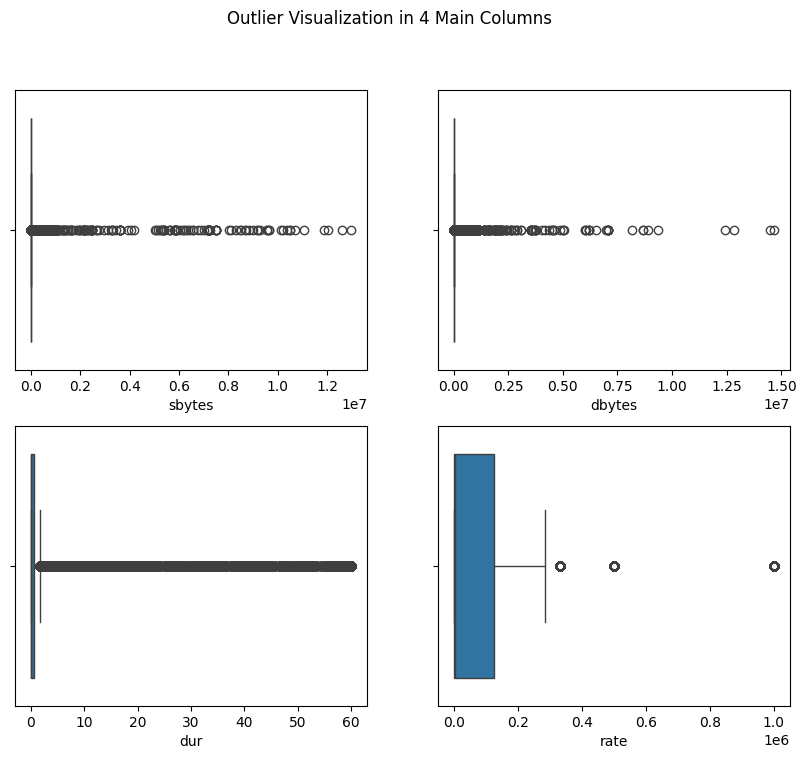

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))
fig.suptitle('Outlier Visualization in 4 Main Columns')
sns.boxplot(x=train_csv_raw['sbytes'], ax=axes[0,0])
sns.boxplot(x=train_csv_raw['dbytes'], ax=axes[0,1])
sns.boxplot(x=train_csv_raw['dur'], ax=axes[1,0])
sns.boxplot(x=train_csv_raw['rate'], ax=axes[1,1])
plt.savefig("EDA_images/task1_outlier_visualization.png", dpi=300)

plt.tight_layout()
plt.show()




Testing Graphs


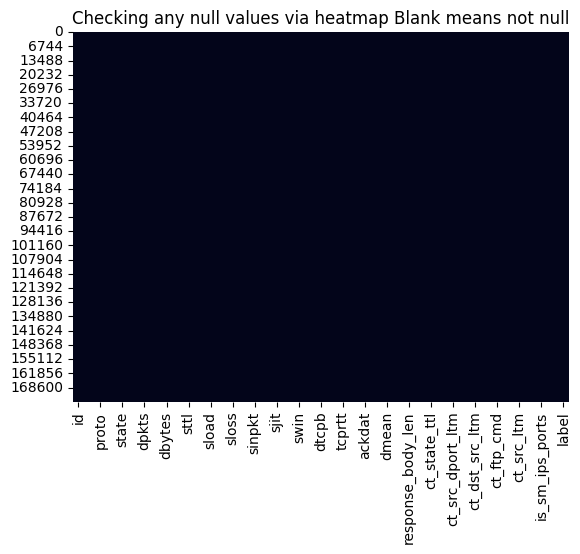

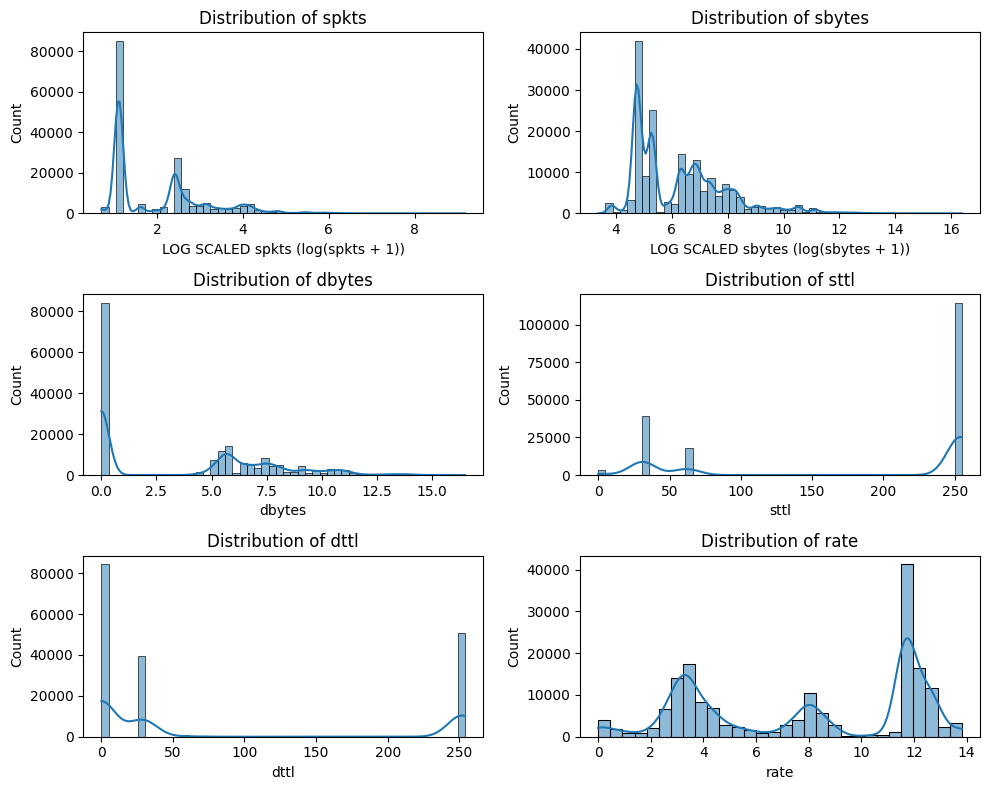

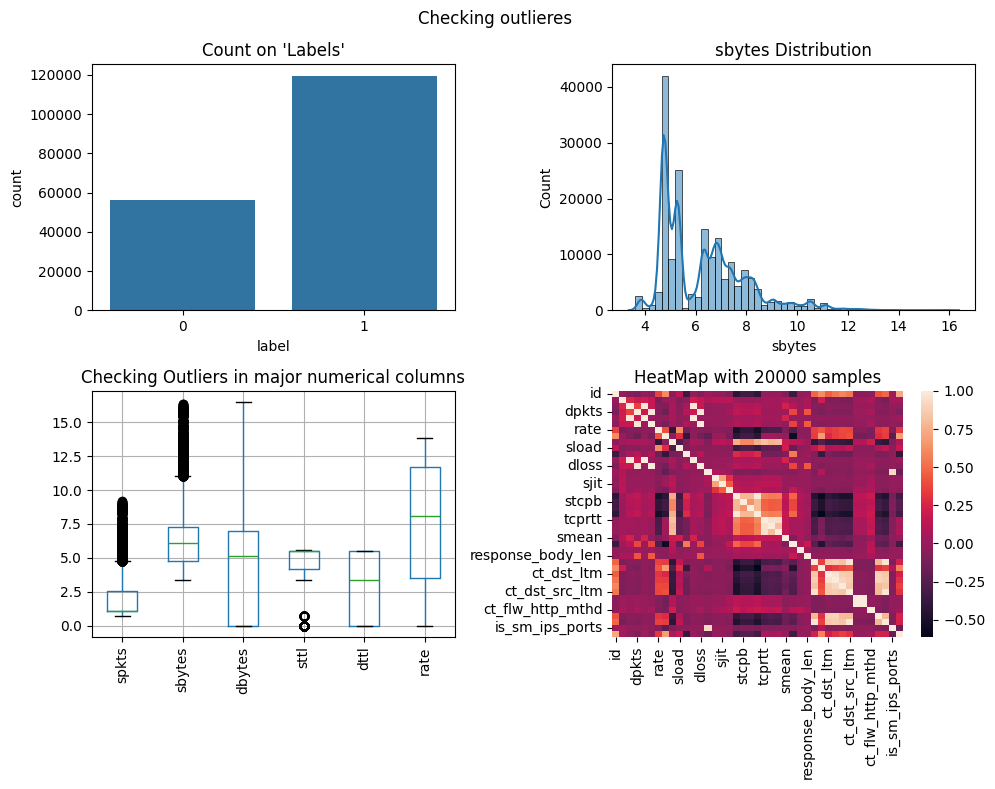

In [ ]:
print("="*40)
print("Testing Graphs")

import numpy as np

sns.heatmap(train_csv_raw.isnull(), cbar=False)
plt.title("Checking any null values via heatmap Blank means not null")
plt.savefig("EDA_images/task1_null_value_check.png", dpi=300)

plt.show()

# Distribution & Outliers in major columns (log scaling if necessary)
fit, axes = plt.subplots(3, 2, figsize=(10,8))
sns.histplot(np.log1p(train_csv_raw['spkts']), bins=50, ax=axes[0,0], kde=True) #log scaled since the values are highly left-skewed
axes[0,0].set_title('Distribution of spkts')
axes[0,0].set_xlabel("LOG SCALED spkts (log(spkts + 1))")

sns.histplot(np.log1p(train_csv_raw['sbytes']), bins=50, ax=axes[0,1], kde=True)
axes[0,1].set_title('Distribution of sbytes')
axes[0,1].set_xlabel("LOG SCALED sbytes (log(sbytes + 1))")

sns.histplot(np.log1p(train_csv_raw['dbytes']), bins=50, ax=axes[1,0], kde=True)
axes[1,0].set_title('Distribution of dbytes')
axes[1,0].set_xlabel("dbytes")

sns.histplot(train_csv_raw['sttl'], bins=50, ax=axes[1,1], kde=True)
axes[1,1].set_title('Distribution of sttl')
axes[1,1].set_xlabel("sttl")

sns.histplot(train_csv_raw['dttl'], bins=50, ax=axes[2,0], kde=True)
axes[2,0].set_title('Distribution of dttl')
axes[2,0].set_xlabel("dttl")

sns.histplot(np.log1p(train_csv_raw['rate']), bins=30, ax=axes[2,1], kde=True)
axes[2,1].set_title('Distribution of rate')
axes[2,1].set_xlabel("rate")

plt.savefig("EDA_images/task1_six_cols_distribution.png", dpi=300)

plt.tight_layout()
plt.show()

print("="*40)


fig, axes = plt.subplots(2, 2, figsize=(10,8))
fig.suptitle('Checking outlieres')

sns.countplot(x='label', data=train_csv_raw, ax=axes[0,0])
axes[0,0].set_title('Count on \'Labels\'')

#sbyte is the data send
sns.histplot(np.log1p(train_csv_raw['sbytes']), bins=50, ax=axes[0,1], kde=True)
axes[0,1].set_title('sbytes Distribution')

## checking outliers (all numeric columns)
selected_num_cols = ['spkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'rate']
np.log1p(train_csv_raw[selected_num_cols]).boxplot(ax=axes[1,0])
axes[1,0].set_title('Checking Outliers in major numerical columns')
axes[1,0].tick_params(axis='x', rotation=90)

import matplotlib.pyplot as plt
# Reducing the number of sample for faster view
sample_df = train_csv_raw.sample(20000, random_state=42)

sns.heatmap(sample_df.corr(numeric_only=True), ax=axes[1,1])
axes[1,1].set_title('HeatMap with 20000 samples')

plt.savefig("EDA_images/task1_Outlier_heatmap.png", dpi=300)


plt.tight_layout()
plt.show()

### Conclusion
Outliers may exist in sload, stcpp, dtcpp, implying unusual activity.

## Define Customer transformer

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# using tqdm status printer
tqdm.pandas()

class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Class used to encode data into model trainable format.
    Based on the model it can distinguish catetorical and numerical columns and
    Conducts proper encoding.
    + also it can do outliers/missing values/ noise(pollishing) detection.
    """
    def __init__(self, use_extra_features=True):
        self.use_extra_features = use_extra_features

    def fit(self, X, y=None):
        return self

    # Juwon Custom
    def cat_num_encoding(self, X_train, X_test, needCat=True) -> pd.DataFrame:
        # Distinguish categorical numerical columns
        cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

        # =========================
        # Print Summary
        # =========================
        print("\n" + "=" * 60)
        print("Encoding & Scaling Summary")
        print("=" * 60)

        print(f"Train shape : {X_train.shape}")
        print(f"Test  shape : {X_test.shape}\n")

        print(f"Numerical columns ({len(num_cols)}):")
        print("  - " + ", ".join(num_cols) if num_cols else "  - None")

        print(f"\nCategorical columns ({len(cat_cols)}):")
        print("  - " + ", ".join(cat_cols) if cat_cols else "  - None")

        print("=" * 60)

        # =========================
        # Numerical Scaling
        # =========================
        scaler = StandardScaler()

        if num_cols:
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_test[num_cols] = scaler.transform(X_test[num_cols])
            print("\nNumerical Scaling Completed\n")
            print("StandardScaler applied to numerical columns")
            print("=" * 60)

        # =========================
        # Categorical Label Encoding
        # =========================
        encoders = {}
        if needCat:
          print("\nCategorical Label Encoding Started\n")
          for col in tqdm(cat_cols, desc="Label Encoding"):
              le = LabelEncoder()

              X_train[col] = le.fit_transform(X_train[col].astype(str))

              X_test[col] = X_test[col].astype(str).map(
                  lambda x: le.transform([x])[0] if x in le.classes_ else -1
              )

              encoders[col] = le

              # print output
              print(f"Encoded column: {col}")
              print(f"  Classes: {list(le.classes_)}")
          print("\n\n**LabelEncoder** applied to categorical columns")
          print("=" * 60)

          print("\nEncoding complete")
          print("=" * 60)
        else:
          print("\nCategorical columns removed")
          print("=" * 60)

        return X_train, X_test, encoders


    # Transform X(train or test) and add new features
    def transform(self, X):
        X_transformed = X.copy()
        if self.use_extra_features:
            # --- JUWON'S LOGIC GOES HERE LATER ---
            # For now, we create a dummy feature so the logic holds
            # Example: Interaction between Duration and Source Bytes
            if 'spkts' in X.columns and 'dpkts' in X.columns:
                X_transformed['pkt_ratio'] = (X_transformed['spkts'] + 1)/(X_transformed['dpkts'] + 1)
            if 'sttl' in X.columns and 'dttl' in X.columns:
              X_transformed['ttl_gap'] = abs(X_transformed['sttl'] - X_transformed['dttl'])
        return X_transformed



# Generate new_columns
transformer = CustomFeatureTransformer()
# New features added (pkt_ratio, ttl_gap)
train_transformed = transformer.transform(train_csv_raw)
test_transformed = transformer.transform(test_csv_raw)

print(train_transformed.head())


# cat_num_encoding# Unpack the validation set
# X_train, y_train, X_val, y_val, X_test, y_test already defined on top (LabelEncoded)


   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  \
0  ...             0           0                 0           1           1   
1  ...             0           0                 0           1           6   
2  ...             0           0                 0           2           6   
3  ...             1           1                 0           2           1   
4  ...             0           0                 0           2          39   

   is_sm_ips_ports  attack_cat  label  pkt_ratio  

/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Feature engineering & Data preprocessing
- split train/test (Already done)
- StandardScaler(K-NN), Random Forest(LabelEncoding(only categorical))
- num of features

In [ ]:
# Remove less important columns (Feature Engineering)
"""
Considered Important
> dur, sbytes, dbytes, rate,
spkts, dpkts,
sttl, dttl,
sinpkt, dinpkt,
sjit, djit,
ct_srv_src, ct_srv_dst, ct_dst_src_ltm
proto/service/state (label-encoding)
is_ftp_login, ct_ftp_cmd


Less Important
- id, label, attack_cat(NEED to DELETE in X)
"""
def report_feature_dropping(
    X_train,
    X_test,
    drop_cols,
    title="Feature Dropping Report (Just for Visualization Purpose, Already done before)"
):
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)

    # ---------- BEFORE ----------
    print("\n[BEFORE DROP, New Features already added]")
    print(f"Train shape : {X_train.shape}")
    print(f"Test  shape : {X_test.shape}")
    print(f"Train columns ({len(X_train.columns)}):")
    print(list(X_train.columns))

    # ---------- DROP ----------
    filtered_X_train = X_train.drop(drop_cols, axis=1, errors="ignore")
    filtered_X_test  = X_test.drop(drop_cols, axis=1, errors="ignore")

    dropped_cols = set(X_train.columns) - set(filtered_X_train.columns)

    # ---------- ALIGN ----------
    filtered_X_train, filtered_X_test = filtered_X_train.align(
        filtered_X_test, join="left", axis=1, fill_value=0
    )

    # ---------- AFTER ----------
    print("\n" + "-" * 80)
    print("[AFTER DROP & ALIGN]")
    print(f"Train shape : {filtered_X_train.shape}")
    print(f"Test  shape : {filtered_X_test.shape}")
    print(f"Remaining columns ({len(filtered_X_train.columns)}):")
    print(list(filtered_X_train.columns))

    # ---------- SUMMARY ----------
    print("\n" + "-" * 80)
    print("[SUMMARY]")
    print(f"Dropped columns ({len(dropped_cols)}): {sorted(dropped_cols)}")
    print("Train/Test columns aligned ✔")
    print("=" * 80)

    return filtered_X_train, filtered_X_test

drop_cols = ['label', 'id', 'attack_cat']

# Drop unnecessary columns
filtered_X_train = X_train.copy()
filtered_X_test = X_test.copy()

# Matching train and test columns
filtered_X_train, filtered_X_test = report_feature_dropping(filtered_X_train, filtered_X_test, drop_cols)

# Save column names
X_train_cols = X_train.columns
filtered_train_cols = filtered_X_train.columns




Feature Dropping Report (Just for Visualization Purpose, Already done before)

[BEFORE DROP, New Features already added]
Train shape : (180371, 42)
Test  shape : (38651, 42)
Train columns (42):
['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']

--------------------------------------------------------------------------------
[AFTER DROP & ALIGN]
Train shape : (180371, 42)
Test  shape : (38651, 42)
Remaining columns (42):
['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 's

In [ ]:
# Print the values
print('\nX_train')
print(X_train[:10])
print('\nX_test')
print(X_test[:10])

print("First 5 feature means:")
print(X_train.mean(axis=0)[:5])

print("\nFirst 5 feature std:")
print(X_train.std(axis=0)[:5])

print('\nX_train dtype: ', type(X_train))
print('\nColumn length: ', len(X_train_cols))
print('\nTrain X shape: ', X_train.shape)
print('\nTest X shape: ', X_test.shape)




# Back to DataFrame with Column Name
X_train = pd.DataFrame(X_train, columns=X_train_cols)
X_test = pd.DataFrame(X_test, columns=X_train_cols)


X_train
              dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
102341   0.117938    112        0      2      6      2     986      86   
99037   19.888327     78        0      5     20      0     900       0   
241927   0.438336    112        0      4     10      6     642     268   
129056   0.202640    112        5      4     10      6     790     268   
67302    0.927228    112        0      4     12      8    1010     724   
17559    0.001041    118        2      2      2      2     146     178   
8654    50.004379     78        0      7      6      0     384       0   
202925   0.009831    112        0      4     36     38    2334   16290   
14843    2.456484    112        3      4     14     12     820     682   
240134   2.264078    112        0      4     24     24    1264    1724   

               rate  sttl  ...  ct_dst_ltm  ct_src_dport_ltm  \
102341    59.353221    62  ...           6                 6   
99037      0.955334   254  ...           1      